# Pertussis
1. [Manual](#Manual)
1. [MCMC](#MCMC)
    1. [MCMC Model](#Model)
    1. [MCMC Results](#Results)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from scipy.integrate import odeint
%matplotlib inline

from time import clock, sleep
from datetime import datetime as dt
from pprint import pprint


from pertussis import *

## Data

In [2]:
# report_rate = np.ones(J) * 400 # Danny Cohen paper. pg3
report_rate = np.append(np.ones(7) * 250, np.ones(4) * 1000) # Danny Cohen paper. pg3

data_years, years = cases_yearly()  # per 1e5
data_years *= 400 / 1e5

data_months, months = cases_monthly()  # per 1e5
data_months *= 400 / 1e5


# 1998 Distribution
dist98 = get_dist_98()

# Yearly average cases per 1e4
cases = np.genfromtxt('./data/_imoh/cases.csv', skip_header=1, delimiter=',',usecols=3, filling_values=-1000)
h = np.histogram(cases, bins=np.append(a_l,120))[0] / 16

real_cases = 1e5 * h * report_rate / (5970.6885 * 1e3 * dist98) # per 1e5
real_cases /= 1e5 # fraction
real_cases

63 Yearly data values
192 Monthly data values


array([ 0.53977326,  0.53841534,  0.12900241,  0.08577529,  0.07728519,
        0.11619908,  0.06787821,  0.07697344,  0.14679576,  0.13306868,
        0.0866436 ])

In [3]:
# # Initial Parameters
r_start = 1948
r_end = 2005
step = 1 / N
t_end = expand_time(r_end, start=r_start, step=step)
t_start = expand_time(r_start, start = r_start, step=step)

t_range = np.arange(t_start, t_end, 1)

# Manual
[==================================](#Charting)

|age|pop|ratio
|---|---|---|
|0|21.894|0.003854352
|1\6|21.894|0.003854352
|2\6|21.894|0.003854352
|0.5|65.682|0.011563056
|1|671.0796237|0.118140906
|7|634.652376|0.111728033
|13|703.6386403|0.123872792
|20|478.93896|0.084315304
|25|1491.8239|0.26262968
|45|995.11606|0.175186235
|65+|573.718908|0.101000938

We get $\delta$ from the data, we then have $r=0.7$ so the $\mu = \delta$ vector does not blow up the oldenst age group. This is preparation for when $\mu$ is also from data

In [4]:
# Manual Parameters

death=100
# d = 1.0 ** np.arange(0, 300, 1) * N / death
d = get_delta()
cut98 = expand_time(1998, r_start)

## Age Distriubtion

In [22]:
# Show mean values fit
death = 100
state_0 = collect_state0(death=death)
state_0 = pack_flat(state_0)

# Run ODEs
RES = odeint(hetro_model, state_0, t_range,
             args=(4, 2, np.ones(11)*0.1, 1, r_start))

# Prepare results
x = reduce_time(t_range, start=r_start, step=step)
y = unpack(RES.T, *unpack_values)

# Sum by Age
y_age = sum([a for a in y]).T
model98 = y_age[cut98]

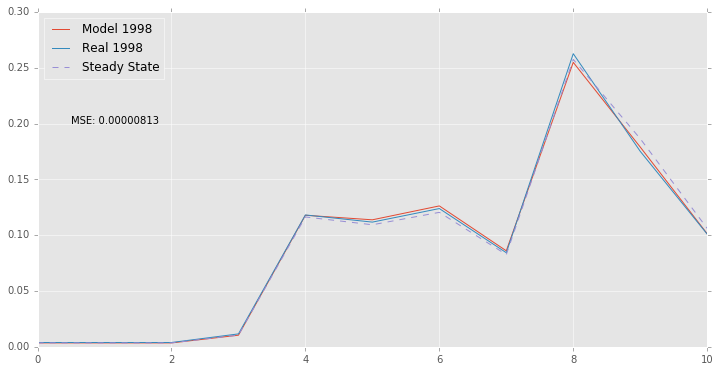

1.0


In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(model98, label='Model 1998')
ax.plot(dist98, label='Real 1998')
ax.plot(y_age[-1], label='Steady State', ls='--')
err = ((model98 - dist98)**2).mean()
ax.annotate("MSE: {:.8f}".format(err), xy = (0.5,0.2))
plt.legend(loc='best')
plt.show()
print (model98.sum())

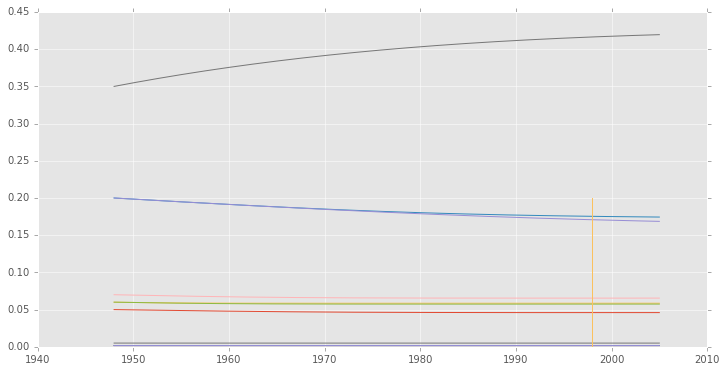

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,y_age[:,:], [1998,1998],[0,0.2])
plt.show()

## Try to fit totals

In [30]:
# Show mean values fit
state_0 = collect_state0(S0=0.8, Is0=1e-3, death=100)
state_0 = pack_flat(state_0)

_o = lambda f,s: np.ones(s)*f

f1,f2,f3 = 550.1,1.5,0.1
s1,s2 = 4,3
s3 = J-s1-s2

f = np.concatenate([_o(f1,s1),_o(f2,s2),_o(f3,s3)])
print (f)
# Run ODEs
RES = odeint(hetro_model, state_0, t_range,
             args=(4, 2, f, 1, r_start ))

# Prepare results
x = reduce_time(t_range, start=1948, step=step)
y = unpack(RES.T, *unpack_values)

# Sum by Age
y_age = sum([a for a in y]).T
# print (y_age)
model98 = y_age[cut98]

h = sum([i for i in y[:3]])
all_compartments = sum([i for i in y])
y.append(h)
y.append(all_compartments)

# Prepare sick people
sick = y[3]
sick = np.apply_along_axis(reduce_year, 1, y[3])[:,1998 - r_start:2014 - r_start]
model_cases = sick.mean(axis=1)

[  5.50100000e+02   5.50100000e+02   5.50100000e+02   5.50100000e+02
   1.50000000e+00   1.50000000e+00   1.50000000e+00   1.00000000e-01
   1.00000000e-01   1.00000000e-01   1.00000000e-01]


MSE:  0.0186436569937


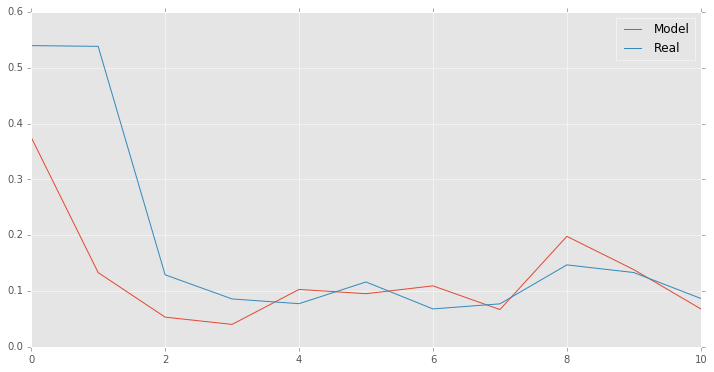

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(model_cases, label='Model')
ax.plot(real_cases, label = "Real")
err = ((model_cases - real_cases)**2).mean()
# ax.annotate("MSE: {:.8f}".format(err), xy = (0.5,0.2))
plt.legend()
print ("MSE: ",err)
plt.show()

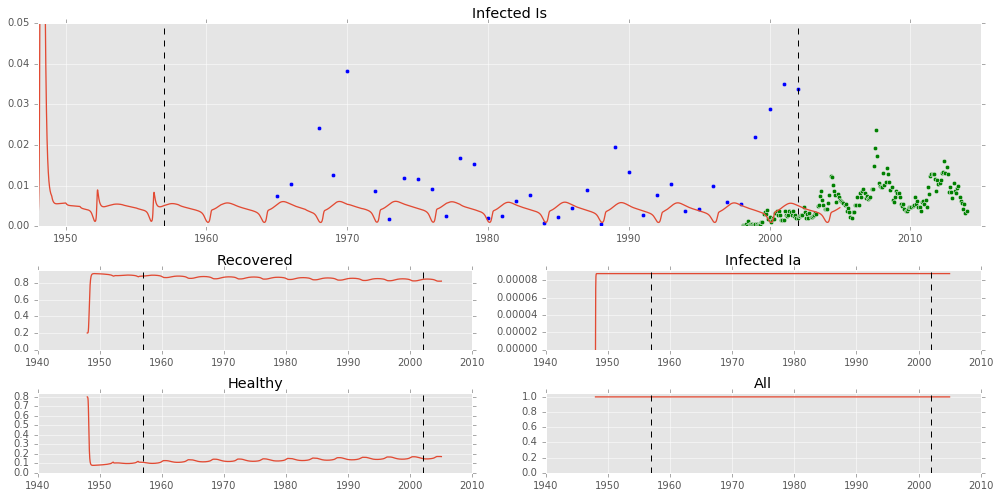

In [32]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
plt.tight_layout()
ax[0].scatter(years, data_years)
ax[0].scatter(months, data_months, c='green')

ax[0].set_xlim(1948, 2015)
ax[0].set_ylim(0, 0.05)
plt.show()

# MCMC
## Initial Parameters

In [ ]:
#######################
###### Run Model ######
#######################
# i0 = pm.Uniform("Is0", 0, 0.1)
# s0 = pm.Uniform("S0", 0.1, 1 - i0)


# # State 0
# @pm.deterministic
# def state_0(S=s0, I=i0):
#     state_0 = collect_state0(S, I)
#     # state_0 = pack_flat(state_0)
#     return state_0

## Model

In [38]:
state_0 = collect_state0()
state_0 = pack_flat(state_0)

# Priors
o = pm.Uniform('omega', 3, 6)
p = pm.Uniform('phi', 0, o + 0.1)
f1 = pm.Uniform('f1', 0, 0.5)
f2 = pm.Uniform('f2', 0, 0.5)
f3 = pm.Uniform('f3', 0, 0.5)
z = pm.Uniform('zeta', 0, 4)

@pm.deterministic
def f(f1=f1, f2=f2, f3=f3):
    s1, s2 = 5, 4
    s3 = J - s1 - s2
    return np.concatenate((f1 * np.ones(s1),
                           f2 * np.ones(s2),
                           f3 * np.ones(s3)))

In [39]:
@pm.deterministic
def sim(o=o, p=p, f=f, z=z):
    # print('A ', end="")
    clk = clock()
    res = odeint(hetro_model, pack_flat(state_0), t_range,
                 args=(o, p, f, z,d ))

    # print (RES.shape)
    # print(RES.sum(axis=1))
    res = unpack(res.T, *unpack_values)
    # print (RES[3].shape)
    # res = reduce_year(RES[3].sum(axis=0))[1951 - t_start:2014 - t_start]
    # print (res.shape)
    # print(clock() - clk)
    return res

In [40]:
@pm.deterministic
def mu1(sim=sim):
    res = reduce_year(sim[3].sum(axis=0))[1951 - r_start:2014 - r_start]
    return res

# @pm.deterministic
# def mu2(sim=sim):
#     res = reduce_month(sim)
#     return res

# TODO: Two sigmas
sigma1 = pm.Uniform('sigma1', 0, 0.5)

In [41]:
# sigma2 = pm.Uniform('sigma2', 0, sigma1/12)
Y1 = pm.Normal('Y1', mu=mu1, tau=1 / sigma1 ** 2, observed=True, value=data_years)
# Y2 = pm.Normal('Y2', mu=mu2, tau=1 / sigma2 ** 2, observed=True, value=data_monthly)

# TODO: Set weights? Is it possible?

# model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, s0, i0, state_0, z])
model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, z])

In [42]:
# TODO: Other Backend
mcmc = pm.MCMC(model, db="ram")
mcmc.sample(iter=20, burn=0)  #######################################################################################

 [-----            15%                  ] 3 of 20 complete in 26.4 secHalting at iteration  2  of  20


# Results
## Prepare Results and run model with parameters

In [ ]:
np.split()

In [88]:
def my_reduce(vec):
    np.split(vec, months)
months = (31, 28, 31, 30,
              31, 30, 31, 31,
              30, 31, 30, 31)
# z = y[3].sum(axis=0)
z = np.ones(365*3)
a = z.reshape(3, 365)
b = a[0]
m = np.cumsum(months)
m
np.split(a,m)
np.apply_along_axis(my_reduce,a,m)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
# m_s = mcmc.trace('S0')[t_tally:].mean()
# m_i = mcmc.trace('Is0')[t_tally:].mean()
t_tally = 0
m_f = mcmc.trace('f')[t_tally:].mean()
m_o = mcmc.trace('omega')[t_tally:].mean()
m_p = mcmc.trace('phi')[t_tally:].mean()
m_z = mcmc.trace('zeta')[t_tally:].mean()

# Show mean values fit
state_0 = collect_state0()
state_0 = pack_flat(state_0)


RES = odeint(hetro_model, state_0, t_range,
             args=(m_o, m_p, m_f, m_z))
# # Results
x = reduce_time(t_range, start=t_start, step=step)
y = unpack(RES.T, *unpack_values)
h = sum([i for i in y[:3]])
all_compartments = sum([i for i in y])
y.append(h)
y.append(all_compartments)

## Charting
[========================](#Manual)

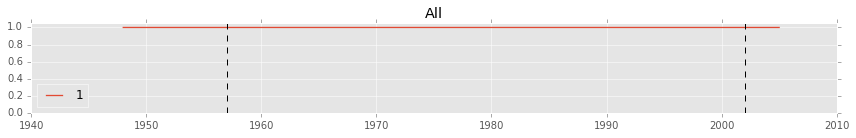

In [33]:
fig, ax = draw_model(x, y[-1:], ["All"], collapse=True)
fig.set_size_inches(12,2)
plt.tight_layout()
z = y[-1:][0]
plt.show()

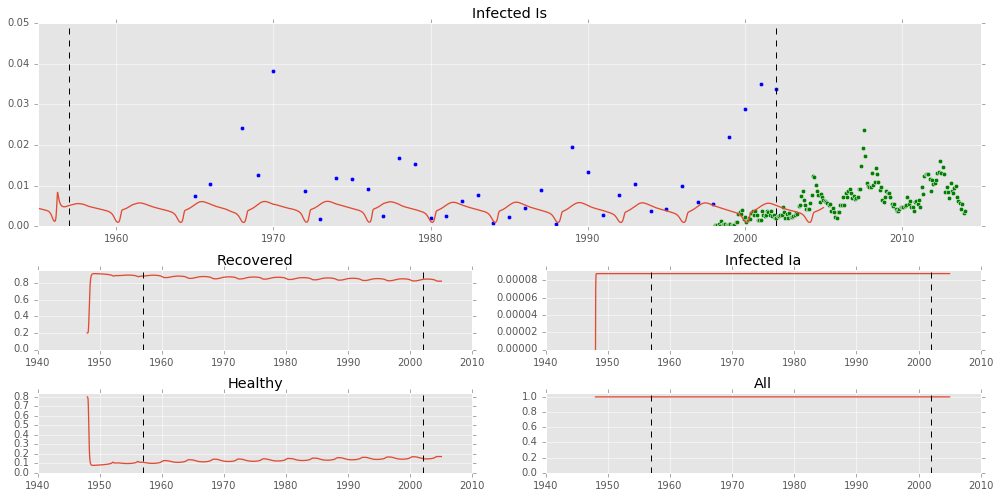

In [36]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
plt.tight_layout()
ax[0].scatter(years, data_years)
ax[0].scatter(months, data_months, c='g')

ax[0].set_xlim(1955, 2015)
ax[0].set_ylim(0, 0.05)
plt.show()

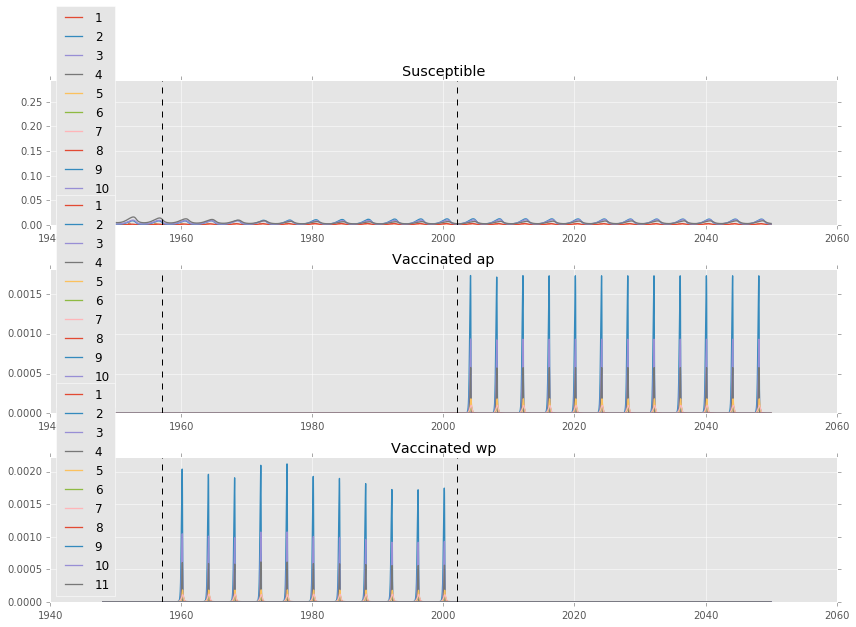

In [148]:
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=False)
plt.tight_layout()
plt.show()

In [256]:
fig4, ax4 = plot_stoch_vars(mcmc)
fig4.savefig('./img/mcmc{}.png'.format(dt.utcnow()).replace(':', '-'))
for ax in ax3:
    ax.set_xlim(1955, 2013)
ax3[0].set_ylim(0, 0.05)

plt.tight_layout()
plt.show()

NameError: name 'mcmc' is not defined

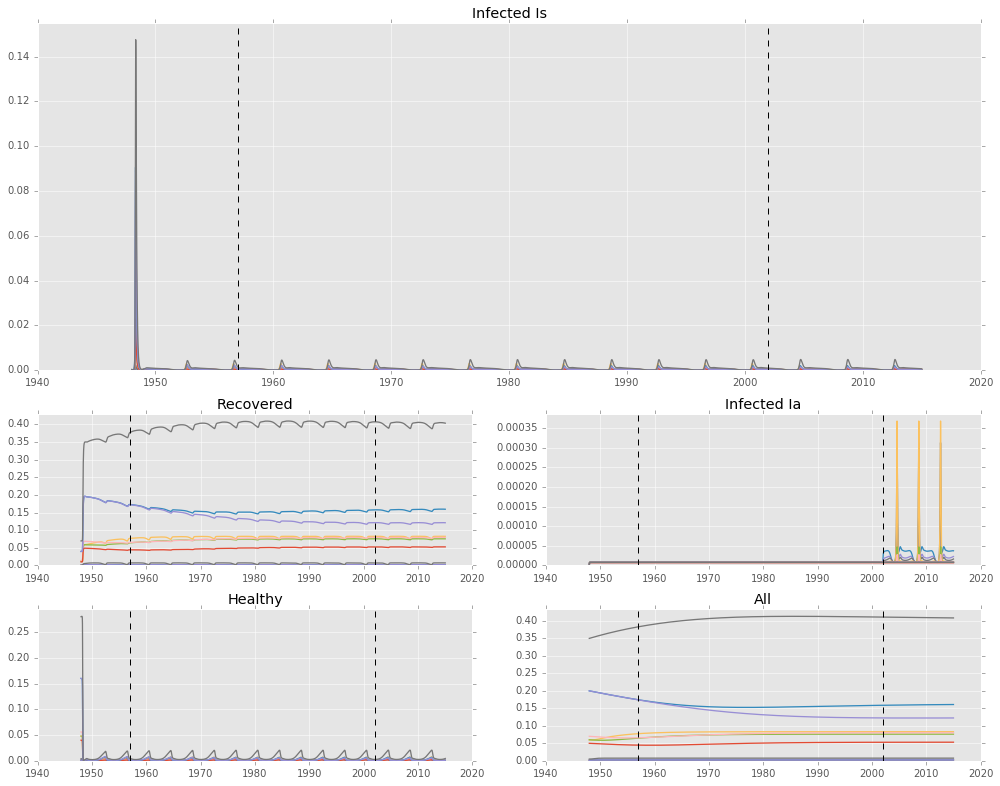

In [257]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=False)

plt.tight_layout()
plt.show()